In [363]:
import os
from pathlib import Path

import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import time

import gym
from gym import error, spaces, utils
from gym.utils import seeding

import pinocchio as pin

from pinocchio.visualize import MeshcatVisualizer
import hppfcl as fcl 
import example_robot_data as erd

from stable_baselines3 import PPO, SAC, A2C
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import VecCheckNan , DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed


import torch

In [364]:
def create_cartpole(N):
    model = pin.Model()
    geom_model = pin.GeometryModel()
    
    parent_id = 0
    
    cart_radius = 0.1
    cart_length = 5 * cart_radius
    cart_mass = 2.
    joint_name = "joint_cart"

    geometry_placement = pin.SE3.Identity()
    geometry_placement.rotation = pin.Quaternion(np.array([0.,0.,1.]),np.array([0.,1.,0.])).toRotationMatrix()
    
    joint_id = model.addJoint(parent_id, pin.JointModelPY(), pin.SE3.Identity(), joint_name)

    body_inertia = pin.Inertia.FromCylinder(cart_mass,cart_radius,cart_length)
    body_placement = geometry_placement
    model.appendBodyToJoint(joint_id,body_inertia,body_placement) # We need to rotate the inertia as it is expressed in the LOCAL frame of the geometry

    shape_cart = fcl.Cylinder(cart_radius, cart_length)

    geom_cart = pin.GeometryObject("shape_cart", joint_id, shape_cart, geometry_placement)
    geom_cart.meshColor = np.array([1.,0.1,0.1,1.])
    geom_model.addGeometryObject(geom_cart)

    #frame=pin.Frame("frame_"+ str(joint_id),model.getFrameId("frame_"+str(parent_id)), parent_id, body_placement, pin.FrameType(3))
    #model.addFrame(frame)
    
    parent_id = joint_id
    joint_placement = pin.SE3.Identity()
    body_mass = 1.
    body_radius = 0.1
    for k in range(N):
        joint_name = "joint_" + str(k+1)
        joint_id = model.addJoint(parent_id,pin.JointModelRX(),joint_placement,joint_name)

        body_inertia = pin.Inertia.FromSphere(body_mass,body_radius)
        body_placement = joint_placement.copy()
        body_placement.translation[2] = 1.
        model.appendBodyToJoint(joint_id,body_inertia,body_placement)

        geom1_name = "ball_" + str(k+1)
        shape1 = fcl.Sphere(body_radius)
        geom1_obj = pin.GeometryObject(geom1_name, joint_id, shape1, body_placement)
        geom1_obj.meshColor = np.ones((4))
        geom_model.addGeometryObject(geom1_obj)

        geom2_name = "bar_" + str(k+1)
        shape2 = fcl.Cylinder(body_radius/4.,body_placement.translation[2])
        shape2_placement = body_placement.copy()
        shape2_placement.translation[2] /= 2.

        geom2_obj = pin.GeometryObject(geom2_name, joint_id, shape2, shape2_placement)
        geom2_obj.meshColor = np.array([0.,0.,0.,1.])
        geom_model.addGeometryObject(geom2_obj)

        #frame=pin.Frame("frame_"+ str(joint_id),model.getFrameId("frame_"+str(parent_id)), parent_id, body_placement, pin.FrameType(3))
        #model.addFrame(frame)
        
        parent_id = joint_id
        joint_placement = body_placement.copy()
    end_frame=pin.Frame("end_pendulum",model.getJointId("joint_"+str(N)), 0, body_placement, pin.FrameType(3))
    model.addFrame(end_frame)
    return model, geom_model
    
def create_pendulum(N):
    #base is fixed
    model = pin.Model()
    geom_model = pin.GeometryModel()

    parent_id = 0
    base_radius = 0.2
    shape_base = fcl.Sphere(base_radius)
    geom_base = pin.GeometryObject("base", 0, shape_base, pin.SE3.Identity())
    geom_base.meshColor = np.array([1.,0.1,0.1,1.])
    geom_model.addGeometryObject(geom_base)
    joint_placement = pin.SE3.Identity()
    body_mass = 1.
    body_radius = 0.1
    for k in range(N):
        joint_name = "joint_" + str(k+1)
        joint_id = model.addJoint(parent_id,pin.JointModelRX(),joint_placement,joint_name)

        body_inertia = pin.Inertia.FromSphere(body_mass,body_radius)
        body_placement = joint_placement.copy()
        body_placement.translation[2] = 1.
        model.appendBodyToJoint(joint_id,body_inertia,body_placement)

        geom1_name = "ball_" + str(k+1)
        shape1 = fcl.Sphere(body_radius)
        geom1_obj = pin.GeometryObject(geom1_name, joint_id, shape1, body_placement)
        geom1_obj.meshColor = np.ones((4))
        geom_model.addGeometryObject(geom1_obj)

        geom2_name = "bar_" + str(k+1)
        shape2 = fcl.Cylinder(body_radius/4.,body_placement.translation[2])
        shape2_placement = body_placement.copy()
        shape2_placement.translation[2] /= 2.

        geom2_obj = pin.GeometryObject(geom2_name, joint_id, shape2, shape2_placement)
        geom2_obj.meshColor = np.array([0.,0.,0.,1.])
        geom_model.addGeometryObject(geom2_obj)
        
        #end_frame=pin.Frame("frame_"+ str(joint_id),model.getFrameId("frame_"+str(parent_id)), parent_id, body_placement, pin.FrameType(3))
        #model.addFrame(end_frame)
        
        parent_id = joint_id
        joint_placement = body_placement.copy()
    end_frame=pin.Frame("end_pendulum_frame",model.getJointId("joint_"+str(N)), 0, body_placement, pin.FrameType(3))
    model.addFrame(end_frame)
    return model, geom_model

In [370]:
model, geom_model = create_cartpole(1)
data = model.createData()
geom_data = geom_model.createData()
q_init = np.zeros(model.nq)
q_init[-1] = 1.1*np.pi
v_init = np.zeros(model.nv)
a_init = np.zeros(model.nv)
pin.forwardKinematics(model,data, q_init)
pin.updateFramePlacements(model, data)

In [371]:
name = "pendulum"
viz = MeshcatVisualizer(model, geom_model, geom_model)
viz.initViewer()
viz.loadViewerModel(name)
viz.display(q_init)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7126/static/


In [372]:
viz.viewer.jupyter_cell()

In [373]:
def aba_with_friction(model,data,q,v,u,cf):
    a = pin.aba(model,data,q,v,u)
    Minv = np.linalg.inv(pin.crba(model,data,q))
    af = np.where(np.abs(v) < 1e-3, 
                  np.sign(a)*np.clip(np.abs(a)-np.abs(np.dot(Minv,np.sign(a)*cf)),0,None),
                  a-np.dot(Minv,np.sign(v)*cf))
    return af

def RK4Update_with_friction(model,data,q,v,u,dt,cf):
    a1 = aba_with_friction(model,data,q,v,u,cf)
    q1,v1 = pin.integrate(model, q,v*dt/2), v+a1*dt/2
    a2 = aba_with_friction(model,data,q1,v1,u,cf)
    q2,v2 = pin.integrate(model, q,v1*dt/2), v+a2*dt/2
    a3 = aba_with_friction(model,data,q2,v2,u,cf)
    q3,v3 = pin.integrate(model, q,v2*dt), v+a3*dt
    a4 = aba_with_friction(model,data,q3,v3,u,cf)
    return pin.integrate(model, q,(dt/3)*((1/2)*v+v1+v2+(1/2)*v3)), v+ (dt/3)*((1/2)*a1 + a2 + a3 + (1/2)*a4)

In [376]:
dt = 0.001
T = 10000
q,v,a = q_init, v_init, a_init
u = np.zeros((T,model.nv))
positions = []
for i in range(T):
    #q,v = RK4Update(model,data, q, v, u[i] , dt)
    q,v = RK4Update_with_friction(model,data, q, v, u[i] , dt, 0.001*np.ones(model.nv))
    #q,v = EulerUpdate(model,data, q, v, u[i], dt)
    pin.forwardKinematics(model, data, q)
    pin.updateGeometryPlacements(model, data, geom_model, geom_data)
    positions += [q.copy()]

In [377]:
viz.play(np.array(positions).T, dt=0.001)

# Controlling a simple pendulum

We learn to control a simple pendulum using PPO algorithm to train a neural policy.

In [386]:
class PEnv(gym.Env):
    
    def __init__(self, dt, T, target = np.array([0.,0.,1.]),w_xterm = 2e-0, w_ureg = 2e-3, w_xcurr= 2e-0, w_xreg = 2e-1):
        super(PEnv, self).__init__()
        #defining dynamical system
        self.model, self.geom_model = create_pendulum(1)
        self.data = self.model.createData()
        self.geom_data = self.geom_model.createData()
        self.action_space = gym.spaces.Box(low=-80., high=80.,
                                        shape=(self.model.nv,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-1000., high=1000.,
                                        shape=(self.model.nq + self.model.nv,), dtype=np.float32)
        
        self.init_state = np.zeros(self.model.nq + self.model.nv)
        self.init_state[0] += 1.0*np.pi
        self.state = self.init_state
        self.instant = 0
        self.dt = dt
        self.T = T
        #defining cost weights
        self.target = target
        self.w_xterm = w_xterm
        self.w_ureg = w_ureg
        self.w_xcurr = w_xcurr
        self.w_xreg = w_xreg
        return 

    def step(self, action):
        #print("action", action)
        q,v = self.RK4Update(action)
        pin.forwardKinematics(self.model, self.data, q, v)
        pin.updateFramePlacements(self.model, self.data)
        self.state = np.concatenate((q,v), axis= 0)
        self.instant += 1
        if self.instant == self.T:
            done = True
        else:
            done = False
        reward = self.compute_reward(self.state, action)
        info = {}
        #print("state",self.state)
        return self.state, reward, done, info

    def reset(self):
        self.instant = 0 
        self.state = self.init_state
        return self.state

    def render(self):
        self.viz.display(self.state[:self.model.nq])
        return
    
    def compute_reward(self, state, action):
        reward = - self.w_ureg*.5*(np.linalg.norm(action)**2 )
        reward += - self.w_xreg*.5*(np.linalg.norm(state[1])**2)
        if self.instant == self.T:
            #reward += - self.w_xterm*.5*(np.linalg.norm(self.angle_normalize(state[0]))**2)
            reward += - self.w_xterm*.5*(np.linalg.norm(data.oMf[-1].translation - self.target)**2)
        else:
            #reward += - self.w_xcurr*.5*(np.linalg.norm(self.angle_normalize(state[0]))**2)
            reward += - self.w_xcurr*.5*(np.linalg.norm(data.oMf[-1].translation - self.target)**2)
        return reward
    
    
    def RK4Update(self,u):
        q,v = self.state[:self.model.nq], self.state[-self.model.nv:]
        a1 = pin.aba(self.model,self.data,q,v,u)
        q1,v1 = pin.integrate(self.model, q,v*self.dt/2), v+a1*self.dt/2
        a2 = pin.aba(self.model,self.data,q1,v1,u)
        q2,v2 = pin.integrate(self.model, q,v1*self.dt/2), v+a2*self.dt/2
        a3 = pin.aba(self.model,self.data,q2,v2,u)
        q3,v3 = pin.integrate(self.model, q,v2*self.dt), v+a3*self.dt
        a4 = pin.aba(self.model,self.data,q3,v3,u)
        return pin.integrate(self.model, q,(self.dt/3)*((1/2)*v+v1+v2+(1/2)*v3)), v+ (self.dt/3)*((1/2)*a1 + a2 + a3 + (1/2)*a4)

    def angle_normalize(self,x):
        return ((x + np.pi) % (2 * np.pi)) - np.pi
    
    
    def close(self):
        return

In [387]:
def make_env(dt, T, seed=0):
    def _init():
        env = PEnv(dt, T)
        return env
    set_random_seed(seed)
    return _init

In [388]:
T = 400
dt = 0.05
env = PEnv(dt, T)

In [389]:
check_env(env)
env.close()

In [390]:
path_curr = Path().cwd()
os.makedirs(path_curr/'logs'/'pendulum_wo_friction'/'PPO', exist_ok=True)

nb_envs = 4
env = SubprocVecEnv([make_env(dt, T, i) for i in range(nb_envs)])
eval_env = SubprocVecEnv([make_env(dt, T, i) for i in range(nb_envs)])
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/pendulum_wo_friction/PPO/',
                             log_path='./logs/pendulum_wo_friction/PPO', n_eval_episodes=1, eval_freq=T*10,
                             deterministic=True)

policy_kwargs = dict(net_arch=[128, 64, 64])#, log_std_init = 2.)

model = PPO("MlpPolicy", env, learning_rate = 1e-4, verbose=0, policy_kwargs = policy_kwargs)

In [383]:
model.learn(total_timesteps=T*5000, callback= eval_callback)
env.close()
eval_env.close()

/home/ROCQ/willow/qlelidec/miniconda3/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=16000, episode_reward=-3931.99 +/- 0.00
Episode length: 400.00 +/- 0.00
New best mean reward!


KeyboardInterrupt: 

In [332]:
path_curr = Path().cwd()
os.makedirs(path_curr/'logs'/'pendulum_wo_friction'/'SAC', exist_ok=True)

env = DummyVecEnv([make_env(dt, T, 0)])
eval_env = DummyVecEnv([make_env(dt, T, 0)])
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/pendulum_wo_friction/SAC/',
                             log_path='./logs/pendulum_wo_friction/SAC', n_eval_episodes=1, eval_freq=T*10,
                             deterministic=True)

policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[64, 64]))

action_noise = NormalActionNoise(0.,.1)#np.zeros((env.model.nv,), dtype= np.float32), 1.)
model = SAC("MlpPolicy", env, verbose=0)#, action_noise = action_noise)

In [333]:
model.learn(total_timesteps=T*1000, callback= eval_callback)
env.close()
eval_env.close()

/home/ROCQ/willow/qlelidec/miniconda3/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=4000, episode_reward=-3278.20 +/- 0.00
Episode length: 400.00 +/- 0.00
New best mean reward!
Eval num_timesteps=8000, episode_reward=-3530.64 +/- 0.00
Episode length: 400.00 +/- 0.00
Eval num_timesteps=12000, episode_reward=-2919.46 +/- 0.00
Episode length: 400.00 +/- 0.00
New best mean reward!
Eval num_timesteps=16000, episode_reward=-2652.31 +/- 0.00
Episode length: 400.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=-2734.54 +/- 0.00
Episode length: 400.00 +/- 0.00
Eval num_timesteps=24000, episode_reward=-2433.20 +/- 0.00
Episode length: 400.00 +/- 0.00
New best mean reward!
Eval num_timesteps=28000, episode_reward=-4256.81 +/- 0.00
Episode length: 400.00 +/- 0.00
Eval num_timesteps=32000, episode_reward=-5472.79 +/- 0.00
Episode length: 400.00 +/- 0.00
Eval num_timesteps=36000, episode_reward=-2154.06 +/- 0.00
Episode length: 400.00 +/- 0.00
New best mean reward!
Eval num_timesteps=40000, episode_reward=-2526.86 +/- 0.00
Episode length

Eval num_timesteps=352000, episode_reward=-2062.38 +/- 0.00
Episode length: 400.00 +/- 0.00
Eval num_timesteps=356000, episode_reward=-2240.88 +/- 0.00
Episode length: 400.00 +/- 0.00
Eval num_timesteps=360000, episode_reward=-2250.99 +/- 0.00
Episode length: 400.00 +/- 0.00
Eval num_timesteps=364000, episode_reward=-2251.00 +/- 0.00
Episode length: 400.00 +/- 0.00
Eval num_timesteps=368000, episode_reward=-2248.33 +/- 0.00
Episode length: 400.00 +/- 0.00
Eval num_timesteps=372000, episode_reward=-2210.20 +/- 0.00
Episode length: 400.00 +/- 0.00
Eval num_timesteps=376000, episode_reward=-2043.92 +/- 0.00
Episode length: 400.00 +/- 0.00
Eval num_timesteps=380000, episode_reward=-2004.19 +/- 0.00
Episode length: 400.00 +/- 0.00
Eval num_timesteps=384000, episode_reward=-2211.78 +/- 0.00
Episode length: 400.00 +/- 0.00
Eval num_timesteps=388000, episode_reward=-2209.57 +/- 0.00
Episode length: 400.00 +/- 0.00
Eval num_timesteps=392000, episode_reward=-2198.95 +/- 0.00
Episode length: 400.

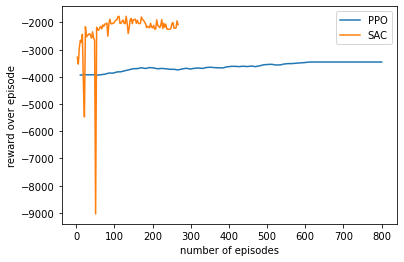

In [334]:
res_trainPPO =  np.load("logs/pendulum_wo_friction/PPO/evaluations.npz")
res_trainSAC =  np.load("logs/pendulum_wo_friction/SAC/evaluations.npz")

plt.figure()
plt.plot(res_trainPPO["timesteps"]/1500., res_trainPPO["results"][:,0], label = "PPO")
plt.plot(res_trainSAC["timesteps"]/1500., res_trainSAC["results"][:,0], label = "SAC")
plt.xlabel("number of episodes")
plt.ylabel("reward over episode")
plt.legend()
plt.show()

In [335]:
env = PEnv(dt, T)

In [318]:
model = PPO.load("logs/pendulum_wo_friction/PPO/best_model")

In [336]:
obs = env.reset()
states =[]
actions = []
rewards = []
for i in range(T):
    action, _states = model.predict(obs)
    action = env.action_space.sample()
    actions += [action]
    obs, reward, dones, info = env.step(action)
    states += [obs]
    rewards += [reward]
env.close()

In [337]:
viz = MeshcatVisualizer(env.model, env.geom_model, env.geom_model)
name = "ppo_pendulum"
viz.initViewer()
viz.loadViewerModel(name)
viz.display(env.state[:env.model.nq])
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7114/static/


In [338]:
viz.display(states[0][:env.model.nv])
time.sleep(1.)
viz.play(np.array(states)[:,:env.model.nv].T, dt=dt)

In [262]:
print("ACTIONS")
print(actions)
print("STATES")
print(states)
print("REWARDS")
print(rewards)
print(sum(rewards))

ACTIONS
[array([-1.0645205], dtype=float32), array([-0.09662913], dtype=float32), array([0.15386742], dtype=float32), array([1.7284966], dtype=float32), array([1.3569325], dtype=float32), array([1.6048483], dtype=float32), array([0.36631703], dtype=float32), array([1.2900885], dtype=float32), array([0.7746459], dtype=float32), array([1.3930979], dtype=float32), array([-1.4303135], dtype=float32), array([-0.83915615], dtype=float32), array([1.530959], dtype=float32), array([0.59616834], dtype=float32), array([-0.53015554], dtype=float32), array([0.632903], dtype=float32), array([-1.5119307], dtype=float32), array([0.3305736], dtype=float32), array([1.8033603], dtype=float32), array([-1.4360288], dtype=float32), array([-0.9839866], dtype=float32), array([1.4389266], dtype=float32), array([0.36735916], dtype=float32), array([-1.9028033], dtype=float32), array([0.4717464], dtype=float32), array([0.9001923], dtype=float32), array([-1.5696442], dtype=float32), array([-1.597913], dtype=float3

# Controlling a simple pendulum with frictions

The task of controlling a simple pendulum is made slightly more difficult by adding dry frictions on the joint.

In [391]:
class FrictionPEnv(gym.Env):
    
    def __init__(self, friction, dt, T, target = np.array([0.,0.,1.]),w_xterm = 2e-0, w_ureg = 2e-3, w_xcurr= 2e-0, w_xreg = 2e-1):
        super(FrictionPEnv, self).__init__()
        #defining dynamical system
        self.model, self.geom_model = create_pendulum(1)
        self.data = self.model.createData()
        self.geom_data = self.geom_model.createData()
        self.action_space = gym.spaces.Box(low=-100., high=100.,
                                        shape=(self.model.nv,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-1000., high=1000.,
                                        shape=(self.model.nq + self.model.nv,), dtype=np.float32)
        self.friction = friction
        self.init_state = np.zeros(self.model.nq + self.model.nv)
        self.init_state[0] += 1.0*np.pi
        self.state = self.init_state
        self.instant = 0
        self.dt = dt
        self.T = T
        #defining cost weights
        self.target = target
        self.w_xterm = w_xterm
        self.w_ureg = w_ureg
        self.w_xcurr = w_xcurr
        self.w_xreg = w_xreg
        #define visualizer for rendering
        #name = "pendulum"
        #self.viz = MeshcatVisualizer(self.model, self.geom_model, self.geom_model)
        #self.viz.initViewer()
        #self.viz.loadViewerModel(name)
        #self.viz.display(self.state[:self.model.nq])
        return 

    def step(self, action):
        #print("action", action)
        q,v = self.RK4Update_with_friction(action)
        pin.forwardKinematics(self.model, self.data, q, v)
        pin.updateFramePlacements(self.model, self.data)
        self.state = np.concatenate((q,v), axis= 0)
        self.instant += 1
        if self.instant == self.T:
            done = True
        else:
            done = False
        reward = self.compute_reward(self.state, action)
        info = {}
        #print("state",self.state)
        return self.state, reward, done, info

    def reset(self):
        self.instant = 0 
        self.state = self.init_state
        return self.state

    def render(self):
        self.viz.display(self.state[:self.model.nq])
        return
    
    def compute_reward(self, state, action):
        reward = - self.w_ureg*.5*(np.linalg.norm(action)**2)
        reward += - self.w_xreg*.5*(np.linalg.norm(state[1])**2)
        if self.instant == self.T:
            reward += - self.w_xterm*.5*(np.linalg.norm(self.data.oMf[1].translation - self.target)**2)
        else:
            reward += - self.w_xcurr*.5*(np.linalg.norm(self.data.oMf[1].translation - self.target)**2)
        return reward
    
    def aba_with_friction(self,model,data,q,v,u,cf):
        a = pin.aba(model,data,q,v,u)
        Minv = np.linalg.inv(pin.crba(model,data,q))
        af = np.where(np.abs(v) < 1e-3, 
                      np.sign(a)*np.clip(np.abs(a)-np.abs(np.dot(Minv,np.sign(a)*cf)),0,None),
                      a-np.dot(Minv,np.sign(v)*cf))
        return af
    
    def RK4Update_with_friction(self,u):
        cf = self.friction*np.ones(u.shape)
        q,v = self.state[:self.model.nq], self.state[-self.model.nv:]
        a1 = self.aba_with_friction(self.model,self.data,q,v,u,cf)
        q1,v1 = pin.integrate(self.model, q,v*self.dt/2), v+a1*self.dt/2
        a2 = self.aba_with_friction(self.model,self.data,q1,v1,u,cf)
        q2,v2 = pin.integrate(self.model, q,v1*self.dt/2), v+a2*self.dt/2
        a3 = self.aba_with_friction(self.model,self.data,q2,v2,u,cf)
        q3,v3 = pin.integrate(self.model, q,v2*self.dt), v+a3*self.dt
        a4 = self.aba_with_friction(self.model,self.data,q3,v3,u,cf)
        return pin.integrate(self.model, q,(self.dt/3)*((1/2)*v+v1+v2+(1/2)*v3)), v+ (self.dt/3)*((1/2)*a1 + a2 + a3 + (1/2)*a4)

    
    def close(self):
        return

In [392]:
def make_env( friction, dt, T, seed=0):
    def _init():
        env = FrictionPEnv(friction, dt, T)
        return env
    set_random_seed(seed)
    return _init

In [393]:
friction = 0.01
T = 1000
dt = 0.005
env = FrictionPEnv(friction, dt, T)

In [394]:
check_env(env)
env.close()

PPO algorithm

In [399]:
path_curr = Path().cwd()
os.makedirs(path_curr/'logs'/'pendulum'/'PPO', exist_ok=True)

nb_envs = 4
env = SubprocVecEnv([make_env(friction, dt, T, i) for i in range(nb_envs)])
eval_env = SubprocVecEnv([make_env(friction, dt, T, i) for i in range(nb_envs)])
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/pendulum/PPO/',
                             log_path='./logs/pendulum/PPO', n_eval_episodes=1, eval_freq=T*2,
                             deterministic=True)

policy_kwargs = dict(net_arch=[64, 64], log_std_init = 15.)

model = PPO("MlpPolicy", env, learning_rate = 1e-4, verbose=0, policy_kwargs = policy_kwargs)

ValueError: Error: the model does not support multiple envs; it requires a single vectorized environment.

SAC algorithm

In [403]:
path_curr = Path().cwd()
os.makedirs(path_curr/'logs'/'pendulum'/'SAC', exist_ok=True)

env = DummyVecEnv([make_env(friction, dt, T, i)])
eval_env = DummyVecEnv([make_env(friction, dt, T, i)])
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/pendulum/SAC/',
                             log_path='./logs/pendulum/SAC', n_eval_episodes=1, eval_freq=T*2,
                             deterministic=True)

policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[64, 64]))

action_noise = NormalActionNoise(0.,.1)
model = SAC("MlpPolicy", env, verbose=0, action_noise = action_noise, policy_kwargs = policy_kwargs)

In [404]:
model.learn(total_timesteps=T*1000, callback= eval_callback)
env.close()
eval_env.close()

Eval num_timesteps=2000, episode_reward=-3899.33 +/- 0.00
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=4000, episode_reward=-2747.51 +/- 0.00
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=6000, episode_reward=-2832.37 +/- 0.00
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=8000, episode_reward=-2528.74 +/- 0.00
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=10000, episode_reward=-2525.79 +/- 0.00
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=12000, episode_reward=-2535.94 +/- 0.00
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=14000, episode_reward=-2503.06 +/- 0.00
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=16000, episode_reward=-2467.66 +/- 0.00
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=18000, episode_reward=-2297.95 +/- 0.00
Episode length: 1000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=200

Eval num_timesteps=168000, episode_reward=-1377.81 +/- 0.00
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=170000, episode_reward=-1387.64 +/- 0.00
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=172000, episode_reward=-1389.84 +/- 0.00
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=174000, episode_reward=-1375.10 +/- 0.00
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=176000, episode_reward=-1425.70 +/- 0.00
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=178000, episode_reward=-1385.58 +/- 0.00
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=180000, episode_reward=-1440.29 +/- 0.00
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=182000, episode_reward=-1435.37 +/- 0.00
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=184000, episode_reward=-1469.51 +/- 0.00
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=186000, episode_reward=-1385.14 +/- 0.00
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=188000, episode_reward=-1428.38 +/- 0.00
Episode le

KeyboardInterrupt: 

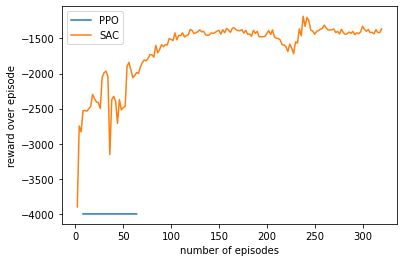

In [406]:
res_trainPPO =  np.load("logs/pendulum/PPO/evaluations.npz")
res_trainSAC =  np.load("logs/pendulum/SAC/evaluations.npz")

plt.figure()
plt.plot(res_trainPPO["timesteps"]/T, res_trainPPO["results"][:,0], label = "PPO")
plt.plot(res_trainSAC["timesteps"]/T, res_trainSAC["results"][:,0], label = "SAC")
plt.xlabel("number of episodes")
plt.ylabel("reward over episode")
plt.legend()
plt.show()

In [407]:
model = PPO.load("logs/pendulum/PPO/best_model")

In [408]:
model = SAC.load("logs/pendulum/SAC/best_model")

In [409]:
env = FrictionPEnv(friction, dt, T)

In [410]:
obs = env.reset()
states =[]
actions = []
rewards = []
for i in range(T):
    action, _states = model.predict(obs)
    actions += [action]
    obs, reward, dones, info = env.step(action)
    states += [obs]
    rewards += [reward]
env.close()

In [411]:
viz = MeshcatVisualizer(env.model, env.geom_model, env.geom_model)
name = "ppo_pendulum"
viz.initViewer()
viz.loadViewerModel(name)
viz.display(env.state[:env.model.nq])
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7113/static/


In [413]:
viz.display(states[0][:env.model.nv])
time.sleep(1.)
viz.play(np.array(states)[:,:env.model.nv].T, dt=dt)

In [111]:
print("ACTIONS")
print(actions)
print("STATES")
print(states)
print("REWARDS")
print(rewards)
print(sum(rewards))

ACTIONS
[array([22.234978], dtype=float32), array([5.3980136], dtype=float32), array([5.83371], dtype=float32), array([18.983746], dtype=float32), array([4.97214], dtype=float32), array([18.985563], dtype=float32), array([-0.9356499], dtype=float32), array([1.3578997], dtype=float32), array([8.987012], dtype=float32), array([15.35795], dtype=float32), array([1.1732569], dtype=float32), array([14.588538], dtype=float32), array([3.7411923], dtype=float32), array([9.975324], dtype=float32), array([2.1896563], dtype=float32), array([7.526044], dtype=float32), array([7.4699883], dtype=float32), array([4.849837], dtype=float32), array([13.574741], dtype=float32), array([15.607276], dtype=float32), array([7.9740553], dtype=float32), array([9.603816], dtype=float32), array([-5.611355], dtype=float32), array([-7.050639], dtype=float32), array([7.4826555], dtype=float32), array([15.260532], dtype=float32), array([8.340062], dtype=float32), array([3.5083246], dtype=float32), array([17.923964], dt

# Controlling a cartpole

We will use PPO and SAC algorithms to learn a neural policy to control a cartpole.

In [205]:
class CartpoleEnv(gym.Env):
    
    def __init__(self, dt, T, target = np.array([0.,0.,1.]),w_xterm = 1e-0, w_ureg = 1e-3, w_xcurr= 1e-0, w_xreg = 1e-2):
        super(CartpoleEnv, self).__init__()
        #defining dynamical system
        self.model, self.geom_model = create_cartpole(1)
        self.data = self.model.createData()
        self.geom_data = self.geom_model.createData()
        self.action_space = gym.spaces.Box(low=-1000., high=1000.,
                                        shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-1000., high=1000.,
                                        shape=(self.model.nq + self.model.nv,), dtype=np.float32)
        self.init_state = np.zeros(self.model.nq + self.model.nv)
        self.init_state[1] += 1.*np.pi
        self.state = self.init_state
        self.instant = 0
        self.dt = dt
        self.T = T
        #defining cost weights
        self.target = target
        self.w_xterm = w_xterm
        self.w_ureg = w_ureg
        self.w_xcurr = w_xcurr
        self.w_xreg = w_xreg
        return 

    def step(self, action):
        #print("action", action)
        u = np.zeros(self.model.nv)
        u[0] = action
        q,v = self.RK4Update(u)
        pin.forwardKinematics(self.model, self.data, q, v)
        pin.updateFramePlacements(self.model, self.data)
        self.state = np.concatenate((q,v), axis= 0)
        self.instant += 1
        if self.instant == self.T:
            done = True
        else:
            done = False
        reward = self.compute_reward(self.state, action)
        info = {}
        #print("state",self.state)
        return self.state, reward, done, info

    def reset(self):
        self.instant = 0 
        self.state = self.init_state
        return self.state

    def render(self):
        self.viz.display(self.state[:self.model.nq])
        return
    
    def compute_reward(self, state, action):
        reward = - self.w_ureg*.5*(np.linalg.norm(action)**2)
        reward += - self.w_xreg*.5*(np.linalg.norm(state)**2)
        if self.instant == self.T:
            #reward += - self.w_xterm*.5*(np.linalg.norm(self.data.oMf[1].translation - self.target)**2)
            reward += - self.w_xterm*.5*(np.linalg.norm(state[1])**2)
        else:
            #reward += - self.w_xcurr*.5*(np.linalg.norm(self.data.oMf[1].translation - self.target)**2)
            reward += - self.w_xcurr*.5*(np.linalg.norm(state[1])**2)
        return reward
    
    def RK4Update(self,u):
        q,v = self.state[:self.model.nq], self.state[-self.model.nv:]
        a1 = pin.aba(self.model,self.data,q,v,u)
        q1,v1 = pin.integrate(self.model, q,v*self.dt/2), v+a1*self.dt/2
        a2 = pin.aba(self.model,self.data,q1,v1,u)
        q2,v2 = pin.integrate(self.model, q,v1*self.dt/2), v+a2*self.dt/2
        a3 = pin.aba(self.model,self.data,q2,v2,u)
        q3,v3 = pin.integrate(self.model, q,v2*self.dt), v+a3*self.dt
        a4 = pin.aba(self.model,self.data,q3,v3,u)
        return pin.integrate(self.model, q,(self.dt/3)*((1/2)*v+v1+v2+(1/2)*v3)), v+ (self.dt/3)*((1/2)*a1 + a2 + a3 + (1/2)*a4)

    
    def close(self):
        return

In [206]:
def make_env( dt, T, seed=0):
    def _init():
        env = CartpoleEnv( dt, T)
        return env
    set_random_seed(seed)
    return _init

In [207]:
T = 3000
dt = 0.005
env = CartpoleEnv(dt, T)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7057/static/


In [208]:
check_env(env)
env.close()

In [209]:
path_curr = Path().cwd()
os.makedirs(path_curr/'logs'/'cartpole_wo_friction'/'PPO', exist_ok=True)

nb_envs = 4
env = SubprocVecEnv([make_env(dt, T, i) for i in range(nb_envs)])
eval_env = SubprocVecEnv([make_env(dt, T, i) for i in range(nb_envs)])
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/cartpole_wo_friction/PPO/',
                             log_path='./logs/cartpole_wo_friction/PPO', n_eval_episodes=1, eval_freq=T*2,
                             deterministic=True)

policy_kwargs = dict(net_arch=[64, 64], log_std_init = 2.)

model = PPO("MlpPolicy", env, learning_rate = 1e-4, verbose=0, policy_kwargs = policy_kwargs)

In [210]:
model.learn(total_timesteps=T*1000, callback= eval_callback)
env.close()
eval_env.close()

Eval num_timesteps=40000, episode_reward=-74.79 +/- 0.00
Episode length: 5000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=80000, episode_reward=-37.11 +/- 0.00
Episode length: 5000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=120000, episode_reward=-63.65 +/- 0.00
Episode length: 5000.00 +/- 0.00
Eval num_timesteps=160000, episode_reward=-74.59 +/- 0.00
Episode length: 5000.00 +/- 0.00
Eval num_timesteps=200000, episode_reward=-155.10 +/- 0.00
Episode length: 5000.00 +/- 0.00
Eval num_timesteps=240000, episode_reward=-163.42 +/- 0.00
Episode length: 5000.00 +/- 0.00
Eval num_timesteps=280000, episode_reward=-144.09 +/- 0.00
Episode length: 5000.00 +/- 0.00
Eval num_timesteps=320000, episode_reward=-76.98 +/- 0.00
Episode length: 5000.00 +/- 0.00
Eval num_timesteps=360000, episode_reward=-30.08 +/- 0.00
Episode length: 5000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=400000, episode_reward=-53.00 +/- 0.00
Episode length: 5000.00 +/- 0.00
Eval num_timesteps=4400

In [184]:
res_trainPPO =  np.load("logs/cartpole_wo_friction/PPO/evaluations.npz")
res_trainSAC =  np.load("logs/cartpole_wo_friction/SAC/evaluations.npz")
res_trainA2C =  np.load("logs/cartpole_wo_friction/A2C/evaluations.npz")

plt.figure()
plt.plot(res_trainPPO["timesteps"]/1500., res_trainPPO["results"][:,0], label = "PPO")
plt.xlabel("number of episodes")
plt.ylabel("reward over episode")
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'logs/cartpole_wo_friction/SAC/evaluations.npz'

In [211]:
env = CartpoleEnv(dt, T)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7070/static/


In [212]:
model = PPO.load("logs/cartpole_wo_friction/PPO/best_model")

In [213]:
obs = env.reset()
states =[]
actions = []
rewards = []
for i in range(T):
    action, _states = model.predict(obs)
    action = env.action_space.sample()
    actions += [action]
    obs, reward, dones, info = env.step(action)
    states += [obs]
    rewards += [reward]
env.close()

In [214]:
viz = MeshcatVisualizer(env.model, env.geom_model, env.geom_model)
name = "ppo_cartpole"
viz.initViewer()
viz.loadViewerModel(name)
viz.display(env.state[:env.model.nq])
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7071/static/


In [215]:
viz.display(states[0][:env.model.nv])
time.sleep(1.)
viz.play(np.array(states)[:,:env.model.nq].T, dt=dt)

In [179]:
print(actions)
#print(states)

[array([-7.1554165], dtype=float32), array([7.6805124], dtype=float32), array([5.7864003], dtype=float32), array([-3.8058567], dtype=float32), array([1.2911395], dtype=float32), array([-0.14633805], dtype=float32), array([1.3601317], dtype=float32), array([0.83190995], dtype=float32), array([0.44975564], dtype=float32), array([2.3550212], dtype=float32), array([-7.7404], dtype=float32), array([2.4306483], dtype=float32), array([3.2368824], dtype=float32), array([7.840842], dtype=float32), array([3.6092777], dtype=float32), array([8.155392], dtype=float32), array([2.1486726], dtype=float32), array([1.3796775], dtype=float32), array([4.4676347], dtype=float32), array([5.258307], dtype=float32), array([-8.524604], dtype=float32), array([1.7601659], dtype=float32), array([6.489054], dtype=float32), array([0.35427886], dtype=float32), array([-5.9605737], dtype=float32), array([8.360276], dtype=float32), array([4.8134003], dtype=float32), array([8.941435], dtype=float32), array([5.1317816], 

# Controlling a cartpole with dry friction

In [443]:
class FrictionalCartpoleEnv(gym.Env):
    
    def __init__(self, dt, T, cf =np.array([3.*9.81*1e-5, 1e-5]), target = np.array([0.,0.,1.]),w_xterm = 1e-0, w_ureg = 1e-3, w_xcurr= 1e-0, w_xreg = 1e-2):
        super(FrictionalCartpoleEnv, self).__init__()
        #defining dynamical system
        self.model, self.geom_model = create_cartpole(1)
        self.data = self.model.createData()
        self.geom_data = self.geom_model.createData()
        self.action_space = gym.spaces.Box(low=-100., high=100.,
                                        shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-1000., high=1000.,
                                        shape=(self.model.nq + self.model.nv,), dtype=np.float32)
        self.init_state = np.zeros(self.model.nq + self.model.nv)
        self.init_state[1] += 1.*np.pi
        self.state = self.init_state
        self.instant = 0
        self.dt = dt
        self.T = T
        #defining cost weights
        self.target = target
        self.w_xterm = w_xterm
        self.w_ureg = w_ureg
        self.w_xcurr = w_xcurr
        self.w_xreg = w_xreg
        # defining friction on joints
        self.cf = cf
        return 

    def step(self, action):
        #print("action", action)
        u = np.zeros(self.model.nv)
        u[0] = action
        q,v = self.RK4Update_with_friction(u)
        pin.forwardKinematics(self.model, self.data, q, v)
        pin.updateFramePlacements(self.model, self.data)
        self.state = np.concatenate((q,v), axis= 0)
        self.instant += 1
        if self.instant == self.T:
            done = True
        else:
            done = False
        reward = self.compute_reward(self.state, action)
        info = {}
        #print("state",self.state)
        return self.state, reward, done, info

    def reset(self):
        self.instant = 0 
        self.state = self.init_state
        return self.state

    def render(self):
        self.viz.display(self.state[:self.model.nq])
        return
    
    def compute_reward(self, state, action):
        reward = - self.w_ureg*.5*(np.linalg.norm(action)**2)
        reward += - self.w_xreg*.5*(np.linalg.norm(state)**2)
        if self.instant == self.T:
            #reward += - self.w_xterm*.5*(np.linalg.norm(self.data.oMf[1].translation - self.target)**2)
            reward += - self.w_xterm*.5*(np.linalg.norm(state[1])**2)
        else:
            #reward += - self.w_xcurr*.5*(np.linalg.norm(self.data.oMf[1].translation - self.target)**2)
            reward += - self.w_xcurr*.5*(np.linalg.norm(state[1])**2)
        return reward
    
    def aba_with_friction(self,q,v,u,cf):
        a = pin.aba(self.model,self.data,q,v,u)
        Minv = np.linalg.inv(pin.crba(self.model,self.data,q))
        #Minv = 
        af = np.where(np.abs(v) < 1e-3, 
                      np.sign(a)*np.clip(np.abs(a)-np.abs(np.dot(Minv,np.sign(a)*cf)),0,None),
                      a-np.dot(Minv,np.sign(v)*cf))
        return af

    def RK4Update_with_friction(self,u):
        q,v = self.state[:self.model.nq], self.state[-self.model.nv:]
        a1 = self.aba_with_friction(q,v,u,self.cf)
        q1,v1 = pin.integrate(self.model, q,v*self.dt/2), v+a1*self.dt/2
        a2 = self.aba_with_friction(q1,v1,u,self.cf)
        q2,v2 = pin.integrate(self.model, q,v1*self.dt/2), v+a2*self.dt/2
        a3 = self.aba_with_friction(q2,v2,u,self.cf)
        q3,v3 = pin.integrate(self.model, q,v2*self.dt), v+a3*self.dt
        a4 = self.aba_with_friction(q3,v3,u,self.cf)
        return pin.integrate(self.model, q,(self.dt/3)*((1/2)*v+v1+v2+(1/2)*v3)), v+ (self.dt/3)*((1/2)*a1 + a2 + a3 + (1/2)*a4)
    
    def close(self):
        return

In [444]:
def make_env( dt, T, seed=0):
    def _init():
        env = FrictionalCartpoleEnv( dt, T)
        return env
    set_random_seed(seed)
    return _init

In [445]:
T = 3000
dt = 0.005
env = FrictionalCartpoleEnv(dt, T)

In [446]:
check_env(env)
env.close()

/home/ROCQ/willow/qlelidec/miniconda3/lib/python3.8/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [447]:
path_curr = Path().cwd()
os.makedirs(path_curr/'logs'/'cartpole'/'SAC', exist_ok=True)

env = DummyVecEnv([make_env(dt, T, i)])
eval_env = DummyVecEnv([make_env(dt, T, i)])
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/cartpole/SAC/',
                             log_path='./logs/cartpole/SAC', n_eval_episodes=1, eval_freq=T*2,
                             deterministic=True)

policy_kwargs = dict(net_arch=dict(pi=[64, 64], qf=[64, 64]))

action_noise = NormalActionNoise(0.,.01)
model = SAC("MlpPolicy", env, verbose=0, action_noise = action_noise, policy_kwargs = policy_kwargs)

In [448]:
model.learn(total_timesteps=T*500, callback= eval_callback)
env.close()
eval_env.close()

/home/ROCQ/willow/qlelidec/miniconda3/lib/python3.8/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6000, episode_reward=-14954.50 +/- 0.00
Episode length: 3000.00 +/- 0.00
New best mean reward!
Eval num_timesteps=12000, episode_reward=-4978762.13 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=18000, episode_reward=-2561556.16 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=24000, episode_reward=-17021.18 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=30000, episode_reward=-15671.54 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=36000, episode_reward=-15380.35 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=42000, episode_reward=-15790.90 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=48000, episode_reward=-16162.23 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=54000, episode_reward=-16179.32 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=-16984.67 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=66000, episode_reward=-171

Eval num_timesteps=522000, episode_reward=-2225520.93 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=528000, episode_reward=-6260119.49 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=534000, episode_reward=-7830408.86 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=540000, episode_reward=-6592564.45 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=546000, episode_reward=-5833000.22 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=552000, episode_reward=-10114801.78 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=558000, episode_reward=-9303823.00 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=564000, episode_reward=-9824023.45 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=570000, episode_reward=-9490724.79 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=576000, episode_reward=-8992929.85 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=582000, episode_rewa

Eval num_timesteps=1038000, episode_reward=-6586556.71 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=1044000, episode_reward=-4558308.34 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=1050000, episode_reward=-3188785.25 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=1056000, episode_reward=-1009859.51 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=1062000, episode_reward=-4834077.83 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=1068000, episode_reward=-4367054.50 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=1074000, episode_reward=-2344536.65 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=1080000, episode_reward=-4525722.91 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=1086000, episode_reward=-2586405.54 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=1092000, episode_reward=-2227786.06 +/- 0.00
Episode length: 3000.00 +/- 0.00
Eval num_timesteps=1098000, ep

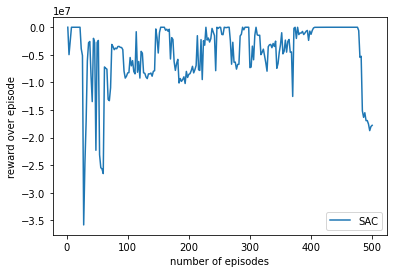

In [449]:
res_trainSAC =  np.load("logs/cartpole/SAC/evaluations.npz")

plt.figure()
plt.plot(res_trainSAC["timesteps"]/T, res_trainSAC["results"][:,0], label = "SAC")
plt.xlabel("number of episodes")
plt.ylabel("reward over episode")
plt.legend()
plt.show()